In [12]:
# from drn_interactions.stats import cv_isi_burst, mannwhitneyu_plusplus
from drn_interactions.io import load_derived_generic, load_neurons_derived
from drn_interactions.transforms import SpikesHandler
from drn_interactions.surrogates import shuffle_spikes
from drn_interactions.transforms.brain_state_transforms import BrainStateUtils
from drn_interactions.responders import BSResonders
from scipy.stats import zscore
from drn_interactions.transforms import segment_spikes
from drn_interactions.stats import cv_isi_burst

import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import numpy as np
import pandas as pd
sns.set_theme(context="poster", style="ticks")

from IPython.display import display


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
eeg_states = load_derived_generic("eeg_states.csv").rename(columns={"cluster": "state"})
neurons = load_neurons_derived()
sessions = get_eeg_sessions().tolist()
clusters = neurons[["neuron_id", "wf_3"]]
sh = SpikesHandler(
    "pre", 
    bin_width=1, 
    session_names=sessions,
     t_start=0, 
     t_stop=1800
    )

## Statistical Modelling

### Spike Rate Change

- Data is binned spike counts aligned with corresponding EEG state.
- Model 1: Repeated Measures ANOVA
$$ Z(\text{SpikeCounts}) \sim 1 + \text{state} + (1 | \text{neuronID}) $$ 

- Model 2: Mixed Anova with Neuron Type
$$ Z(\text{SpikeCounts}) \sim 1 + \text{state} + \text{neuronType} + \text{state}:\text{neuronType} (1 | \text{neuronID}) $$ 


In [14]:
# spike rate

transformer = BrainStateUtils()

df = transformer.align_spikes_state_long(sh, eeg_states)
df["counts"] = df.groupby("neuron_id")["counts"].transform(zscore)
df.head(3)


mod = BSResonders(within_first=False)
out = mod.get_anova(df)
display(out["anova"])
display(out["contrasts"])

# with neuron types
out = mod.get_anova(df, clusters=clusters)
display(out["anova"])
# display(out["contrasts"])

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,state,1,309,20.304,0.0,0.062,1.0


,Contrast,A,B,T,dof,p,Sig
0,state,act,sw,4.506,309.0,0.0,*


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,wf_3,0.329,2,307,0.165,4.249,0.015,0.027,NaN
1,state,5.207,1,307,5.207,20.242,0.000,0.062,1.0
2,Interaction,0.271,2,307,0.135,0.526,0.592,0.003,NaN


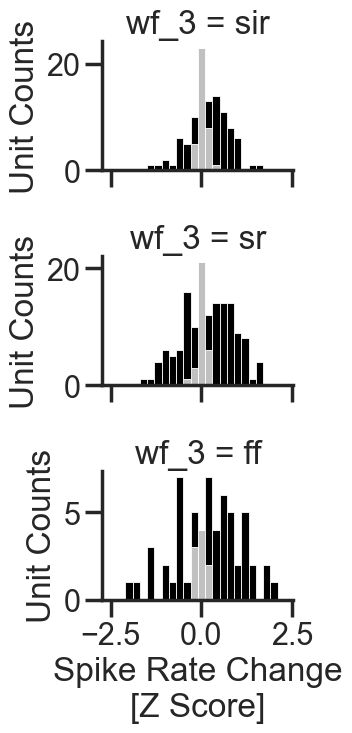

In [20]:
# Post Hoc Tests

responders = mod.get_responders(df, abs_diff_thresh=0.2)
mod.plot_responders(clusters=clusters, bins=np.arange(-2.5, 2.5, 0.2), height=2.5, aspect=1.5)

In [21]:
# surrogate data
sh_surr = shuffle_spikes(sh)

df = transformer.align_spikes_state_long(sh_surr, eeg_states)
df["counts"] = df.groupby("neuron_id")["counts"].transform(zscore)
df.head(3)


mod = BSResonders(within_first=False)
out = mod.get_anova(df)
display(out["anova"])
# display(out["contrasts"])

# with neuron types
out = mod.get_anova(df, clusters=clusters)
display(out["anova"])
# display(out["contrasts"])


,Source,ddof1,ddof2,F,p-unc,np2,eps
0,state,1,309,3.04,0.082,0.01,1.0


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,wf_3,0.001,2,307,0.000,0.228,0.796,0.001,NaN
1,state,0.057,1,307,0.057,3.023,0.083,0.010,1.0
2,Interaction,0.006,2,307,0.003,0.146,0.864,0.001,NaN


In [ ]:
# cv isi


def get_cvisi_in_segment(sh, segment_length=120):
    spikes = sh.spikes.copy()
    spikes = segment_spikes(
        spikes, t_start=sh.t_start, t_stop=sh.t_stop, segment_length=segment_length
    )
    return (
        spikes.groupby(["neuron_id", "segment"])["spiketimes"]
        .apply(cv_isi_burst)
        .to_frame("cv")
        .reset_index()
        .dropna()
    )



spikes = get_cvisi_in_segment(sh, segment_length=60)
df = transformer.align_segmentedspikes_state(spikes, eeg_states, )

In [ ]:
mod = BSResonders(df_value_col="cv", within_first=False)
out = mod.get_anova(df)
display(out["anova"])
display(out["contrasts"])

# with neuron types
out = mod.get_anova(df, clusters=clusters)
display(out["anova"])
display(out["contrasts"])

In [ ]:
responders = mod.get_responders(df, abs_diff_thresh=0.01)
# mod.plot_responders(clusters=clusters,
# bins="auto",
# #  bins=np.arange(-2.5, 2.5, 0.2)
#  )